In [39]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [40]:
pickle_off = open ("data/return_1y.pkl", "rb")
return_1y = pickle.load(pickle_off)

In [41]:
# Detect and remove outliers using IQR
q1 = return_1y['Nifty_50_1y_return'].quantile(0.25)
q3 = return_1y['Nifty_50_1y_return'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
return_1y = return_1y[(return_1y['Nifty_50_1y_return'] >= lower_bound) & (return_1y['Nifty_50_1y_return'] <= upper_bound)]

In [42]:
# Display the cleaned data
print("Cleaned data:")
print(return_1y.head())

Cleaned data:
          us_unemployment_1y_return  FED_RATE_1y_return  india_cpi_1y_return  \
01-12-12                  -0.179412           -3.103896            -3.291962   
01-01-13                  -0.588855           -2.416667            -3.764741   
01-02-13                  -0.070568           -2.333333            -5.170809   
01-04-13                  -0.260163           -0.821429            -0.966911   
01-05-13                  -0.039634           -1.401786            -0.690428   

          bond_Return_1y_return  Nifty_50_1y_return  Dow_Jons_1y_return  \
01-12-12                   -1.0           -1.903389            4.032268   
01-01-13                   -1.0           -1.864414            3.320984   
01-02-13                   -1.0           -3.980358            5.374780   
01-04-13                   -1.0           -2.847341           31.786410   
01-05-13                   -1.0           -2.418810            2.022686   

          S&P_500_1y_return  NASDAQ_1y_return  BRENT_1

In [43]:
# Display the statistics of the cleaned data
print("Statistics of the cleaned data:")
print(return_1y.describe())

Statistics of the cleaned data:
       us_unemployment_1y_return  FED_RATE_1y_return  india_cpi_1y_return  \
count                 100.000000          100.000000           100.000000   
mean                   -3.627393          -20.629413            -3.171461   
std                    13.705841           92.466293            12.557914   
min                   -98.567568         -479.125000          -110.375742   
25%                    -0.782018           -1.708333            -2.863554   
50%                    -0.323235           -0.620397            -1.432163   
75%                     0.126683            0.156944            -0.705514   
max                     6.148936          141.200000            18.144419   

       bond_Return_1y_return  Nifty_50_1y_return  Dow_Jons_1y_return  \
count             100.000000          100.000000          100.000000   
mean               -1.108777           -0.469895            0.506071   
std                 4.117523            1.951017          

In [44]:
# Correlation analysis
corr_matrix_1y = return_1y.corr()
nifty_corr_1y = pd.DataFrame(return_1y.corr()['Nifty_50_1y_return'].sort_values())
nifty_corr_1y

,Nifty_50_1y_return
indiavix_1y_return,-0.256861
BOND_10Y_1y_return,-0.190139
Dow_Jons_1y_return,-0.174061
bond_Return_1y_return,-0.161734
india_cpi_1y_return,-0.131810
NASDAQ_1y_return,-0.069886
S&P_500_1y_return,-0.047181
Inr_Usd_1y_return,-0.041072
FED_RATE_1y_return,0.040045
Gold_1y_return,0.089237


<Axes: >

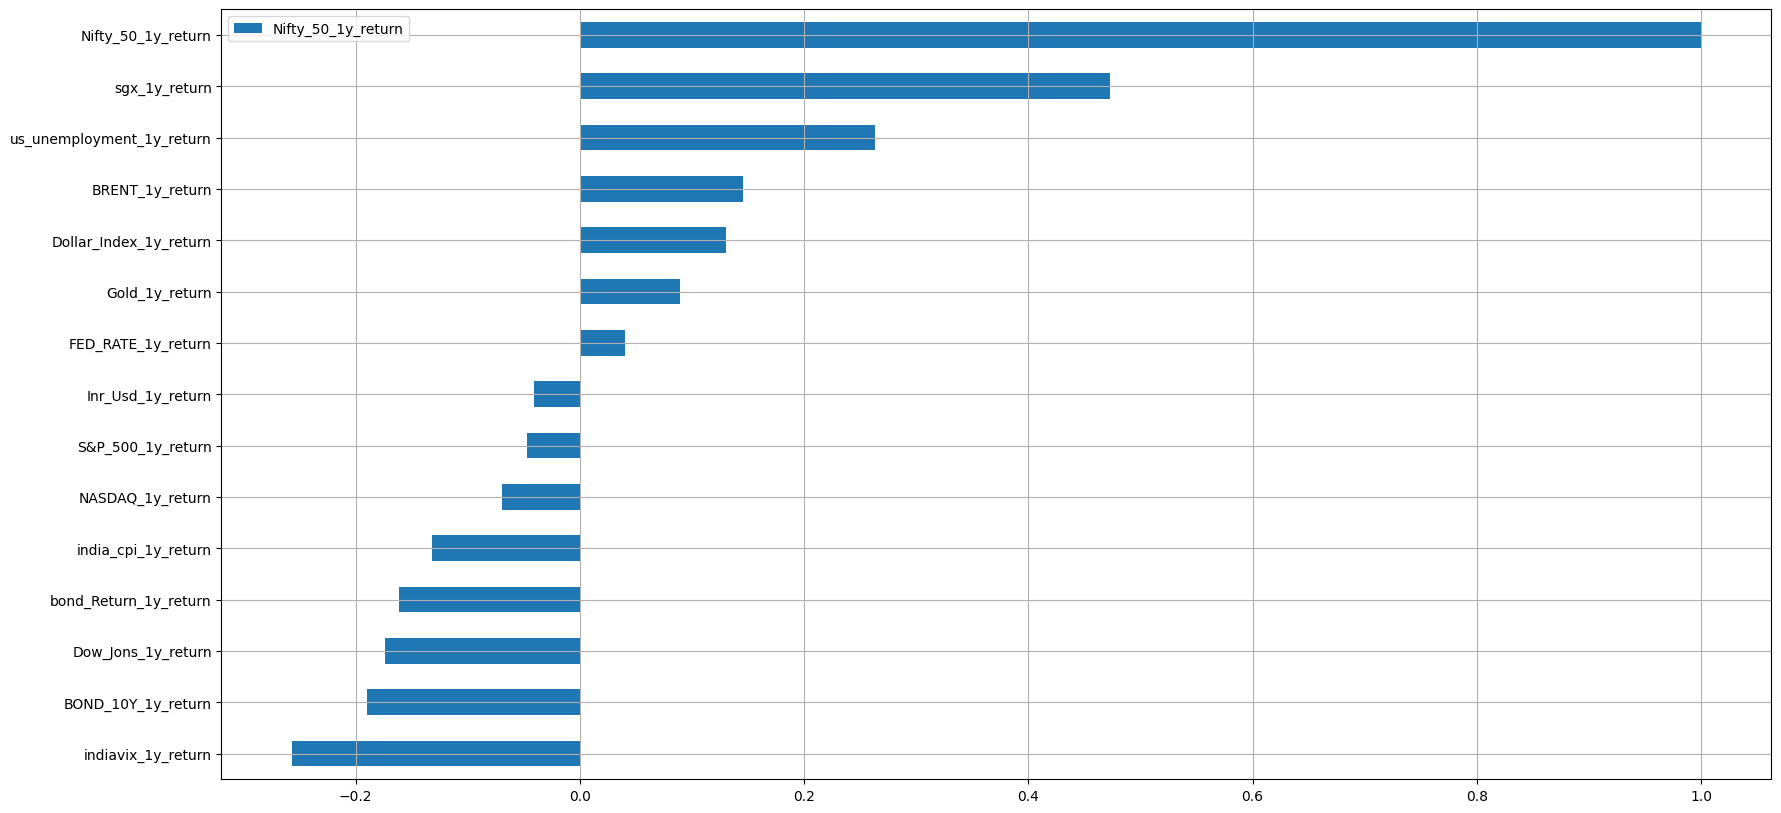

In [45]:
filter = np.abs(nifty_corr_1y)  # this creates a float64 array
mask = filter >= -1  # this creates a boolean mask based on the condition
nifty_corr_1y[mask].plot.barh(figsize=(20,10), grid=True)  # use the boolean mask to index the DataFrame

In [46]:
# Feature selection using mutual information
selector = SelectKBest(score_func=mutual_info_regression, k='all')
X = return_1y.drop(columns='Nifty_50_1y_return')
y = return_1y['Nifty_50_1y_return']
X_new = selector.fit_transform(X, y)
print('Selected features:', X.columns[selector.get_support()])

Selected features: Index(['us_unemployment_1y_return', 'FED_RATE_1y_return',
       'india_cpi_1y_return', 'bond_Return_1y_return', 'Dow_Jons_1y_return',
       'S&P_500_1y_return', 'NASDAQ_1y_return', 'BRENT_1y_return',
       'BOND_10Y_1y_return', 'Gold_1y_return', 'Inr_Usd_1y_return',
       'Dollar_Index_1y_return', 'sgx_1y_return', 'indiavix_1y_return'],
      dtype='object')


In [47]:
# Feature Scaling
scaler = StandardScaler()
X = return_1y.drop(columns='Nifty_50_1y_return')
y = return_1y['Nifty_50_1y_return']
X = scaler.fit_transform(X_new)
y = y.astype('float32')
print(X[-5:])
print(y[-5:])

[[ 2.30143882e-01 -3.45500992e+00  5.54483978e-02  6.39204696e-01
  -1.97781330e-01 -1.32913888e-01 -2.04982844e-01 -1.65747620e-01
   3.57672922e-01  1.74181317e-01  9.48132426e-02 -4.34513197e-01
  -2.96284231e-01  7.68152160e-02]
 [ 2.20739126e-01 -4.31096213e+00  6.19407803e-02  5.23659853e-01
  -1.75755855e-01 -1.27160243e-01 -1.95298837e-01 -1.60888816e-01
   4.30703107e-01  7.52888067e-01  4.80217249e-01  2.11284331e-01
  -2.59655576e-01 -4.66045709e+00]
 [ 2.10661067e-01 -4.70225457e+00  1.72276115e-01  3.71561304e-01
  -2.02014245e-01 -1.44222227e-01 -2.57488866e-01 -1.72537973e-01
   6.73409677e-01  4.47326400e-01  1.36098234e-01 -3.40269460e-02
  -2.46265661e-01  7.00290892e-01]
 [ 2.22793254e-01 -4.98349601e+00  1.78934751e-01  2.53790906e-01
  -2.06886446e-01 -1.59426993e-01 -7.07281569e-01 -1.76348379e-01
   5.80797006e-01 -5.45653021e-01  4.50409926e-01  1.41517770e-01
  -2.89701284e-01 -1.47264301e-01]
 [ 2.02634727e-01  2.24225930e-01  3.19457875e-01  2.67055754e-01
  

Data Cleaning And Transformation Completed

Model Building for Features Importance

In [48]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [49]:
# Define regression models
dtr = DecisionTreeRegressor(max_depth=5)
rfr = RandomForestRegressor(n_estimators=50, random_state=2)
etr = ExtraTreesRegressor(n_estimators=50, random_state=2)
gbr = GradientBoostingRegressor(n_estimators=50, random_state=2)
xgbr = XGBRegressor(n_estimators=50, random_state=2)

In [50]:
regressors = {
    'DTR': dtr,
    'RFR': rfr,
    'ETR': etr,
    'GBR': gbr,
    'XGBR': xgbr
}

In [51]:
def train_regressor(regressor, X_train, y_train, X_test, y_test):
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [52]:
mse_scores = []
r2_scores = []
for name, regressor in regressors.items():
    current_mse, current_r2 = train_regressor(regressor, X_train, y_train, X_test, y_test)
    print(f"For {name}:")
    print(f"MSE: {current_mse:.4f}")
    print(f"R2: {current_r2:.4f}\n")
    mse_scores.append(current_mse)
    r2_scores.append(current_r2)

For DTR:
MSE: 0.2065
R2: 0.9393

For RFR:
MSE: 0.3162
R2: 0.9070

For ETR:
MSE: 0.4743
R2: 0.8605

For GBR:
MSE: 0.1860
R2: 0.9453

For XGBR:
MSE: 0.2701
R2: 0.9205



In [53]:
scaler = StandardScaler()
# Find the index of the model with the lowest MSE score
best_model_index = np.argmin(mse_scores)
# Get the name of the best model
best_model_name = list(regressors.keys())[best_model_index]
# Print the name of the best model
print(f"The best model is {best_model_name} with an MSE of {mse_scores[best_model_index]:.4f}.")
# Train the best model on the full dataset
best_model = regressors[best_model_name]
best_model.fit(scaler.fit_transform(X), y)

The best model is GBR with an MSE of 0.1860.


GradientBoostingRegressor(n_estimators=50, random_state=2)

The best model is GBR with an MSE of 0.1860.

In [54]:
y_pred = etr.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df

,Actual,Predicted
01-06-21,-0.567817,-0.466452
01-07-18,-0.309182,0.207882
01-03-20,-2.913673,-0.871113
01-10-17,4.881368,3.612264
01-09-17,0.648793,0.015984
01-12-16,-1.672808,-1.561832
01-04-15,1.205482,2.952702
01-01-21,-2.759901,-1.999166
01-01-14,-0.040761,0.014274
01-12-12,-1.903389,-1.772327


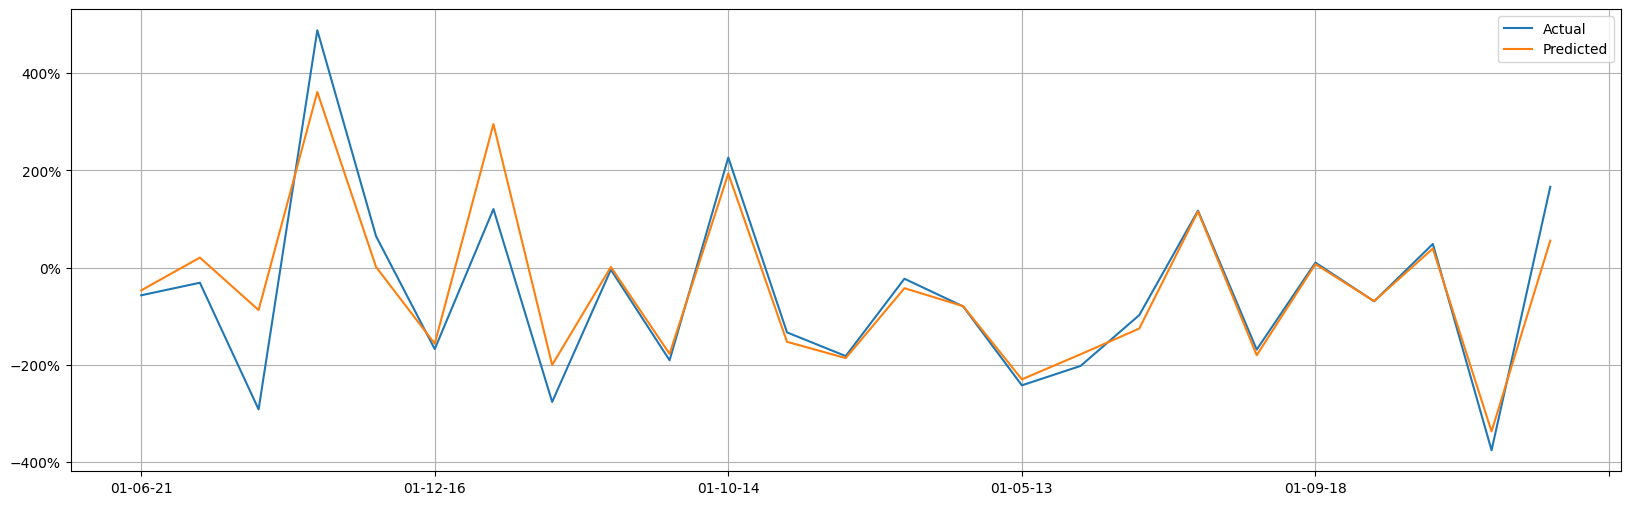

In [55]:
ax = df.plot(figsize=(20,6), grid=True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

C:\Users\Harsh\AppData\Local\Temp\ipykernel_1868\3094767840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


<Axes: xlabel='Nifty_50_1y_return', ylabel='Density'>

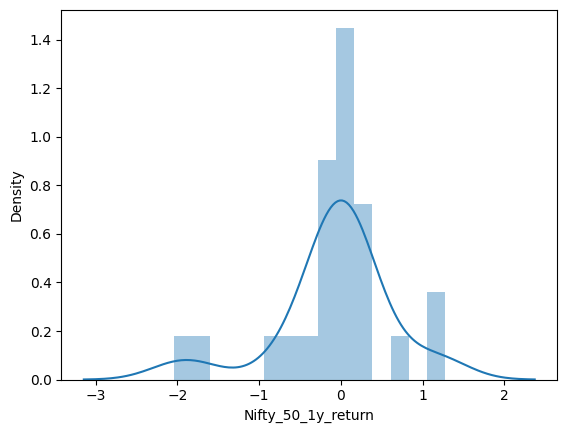

In [56]:
sns.distplot(y_test-y_pred)

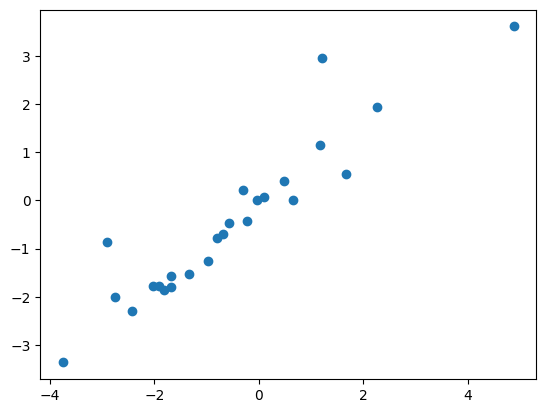

In [57]:
plt.scatter(y_test,y_pred)